In [1]:
# !pip install lava-nc
# !pip install networkx==2.8
# !pip install matplotlib
# !pip install cvxpy
# !pip install lava-nc
# !pip install pandas
import cProfile

In [2]:
import lava
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from mod_one_exchange import mod_one_exchange_approximation
import graph_col_dimacs_reader as reader
import goemans_williamson_sdp as gw_sdp
import scipy
import matplotlib
import re
import time
import sys

In [3]:
def graph_to_mat(G, path = 'test_graphs/default2.mat'):
    # get the adjancency matrix of the graph
    adj = nx.adjacency_matrix(G).todense()
    adj = np.asarray(adj, dtype=np.int32)
    scipy.io.savemat(path, {'M': adj})   # M for matrix, to stay consistent with the .mat files we already have
    return

def mat_to_graph(path):
    mat = scipy.io.loadmat(path)
    G = nx.from_numpy_array(mat['M'])
    return G

In [4]:
from GraphColoringTest import gen_permutation_matrix, get_chr, compute_loss, gen_cyclic_graph
import GraphColoringSoln as GC
from lava.magma.core.run_configs import Loihi1SimCfg
from lava.magma.core.run_conditions import RunSteps
from lava.proc.monitor.process import Monitor


# define a function graph_painter, input would be a adjacency matrix, output should be a 1-d array of colors
def graph_painter(adj):
    # adj is a numpy array
    B = adj
    num_nodes = B.shape[0]
    conns = np.sum(B, axis=1)
    Cscale = 0.1
    C = (1.0 - adj)
    connsC = np.sum(C, axis=1)

    init_range = 0.2*np.pi
    phi_init = np.random.uniform(-init_range, init_range, size=(num_nodes,))
    cos_phi_init = np.cos(phi_init)
    sin_phi_init = np.sin(phi_init)

    lr = 0.1

    lrc = lr*(num_nodes - conns)/(num_nodes)
    lrr = Cscale*lr*conns/(num_nodes)
    tau = 500
    decay = 1 - 1/tau
    sigma = 0.1
    num_steps = 2000

    nodes = GC.OScillatoryNeuron(shape=(num_nodes,), phi=phi_init, sigma=sigma, decay=decay, lrc=lrc, lrr=lrr)
    connections = GC.GraphColorUpdate(shape=(num_nodes,), shape_mat=(num_nodes, num_nodes), B=B, C=C)
    phi_monitor = Monitor()

    nodes.cos_out.connect(connections.cos_in)
    nodes.sin_out.connect(connections.sin_in)

    connections.B_cos_out.connect(nodes.B_cos_in)
    connections.B_sin_out.connect(nodes.B_sin_in)
    connections.C_cos_out.connect(nodes.C_cos_in)
    connections.C_sin_out.connect(nodes.C_sin_in)
    phi_monitor.probe(nodes.phi, num_steps)
    
    nodes.run(condition=RunSteps(num_steps=num_steps), run_cfg=Loihi1SimCfg())
    phi_vals = phi_monitor.get_data()
    nodes.stop()
    print(list(phi_vals.keys()))
    phi_history = phi_vals[list(phi_vals.keys())[0]]['phi']
    # phi_history = phi_vals['Process_0']['phi']

    last_phi = phi_history[-1,:]
    P, order = gen_permutation_matrix(last_phi)
    chromatic_number, min_color_blocks = get_chr(P, adj, order)
    print("order-based chromatic number at simulation end: ", chromatic_number)
    print("color blocks at simulation end: ", min_color_blocks)
    
    print_fr = 500
    chr_ns = []
    min_chr_n = num_nodes
    min_ind = 0
    min_chr_n_color_blocks = [[i] for i in range(num_nodes)]
    for i in range(phi_history.shape[0]):
        if i%print_fr == print_fr-1:
            print("computing for iter: ", i+1)
            print("minimum chromatic number: ", min_chr_n)
        curr_phi = phi_history[i,:]
        P, order = gen_permutation_matrix(curr_phi)
        chr_n, chr_n_color_blocks = get_chr(P, adj, order)  # changes here
        if chr_n<min_chr_n:
            min_chr_n = chr_n
            min_ind = i
            min_chr_n_color_blocks = chr_n_color_blocks
        chr_ns.append(chr_n)
    
    print("minimum order-based chromatic number during simulation: ", min_chr_n)
    print("color blocks at minimum chromatic number: ", min_chr_n_color_blocks)

    return min_chr_n_color_blocks

def get_color_indice_array(color_blocks, adj):
    color_indice_array = np.zeros(adj.shape[0])
    temp_color_index = 0
    for color_block in color_blocks:
        for node in color_block:
            color_indice_array[node] = temp_color_index
        temp_color_index += 1
    num_colors = temp_color_index
    return color_indice_array, num_colors

    

In [5]:
def moe_maxcut(adj):
    G = nx.from_numpy_array(adj)
    cut, cutsize = mod_one_exchange_approximation(G)

    # fig, ax = plt.subplots()
    # nx.draw_circular(G, with_labels=True, node_color=cut, ax=ax)

    # cut consists of ones and zeros, where ones represent the nodes in one subgraph and zeros represent the nodes in the other subgraph
    cut1_size = np.sum(cut)
    cut0_size = len(cut) - cut1_size
    # Create two new adjacent matrices for the two subgraphs given by cut
    adj1 = np.zeros((cut1_size, cut1_size))
    adj0 = np.zeros((cut0_size, cut0_size))
    
    map_index1 = {}
    map_index0 = {}

    reverse_map = {}

    temp1 = 0
    temp0 = 0
    for i in range(len(cut)):
        
        if cut[i] == 1:
            map_index1[temp1] = i
            reverse_map[i] = (1, temp1)
            temp1 += 1
        else:
            map_index0[temp0] = i
            reverse_map[i] = (0, temp0)
            temp0 += 1
    
    for i in range(len(cut)):
        for j in range(len(cut)):
            if cut[i] == 1 and cut[j] == 1:
                adj1[reverse_map[i][1], reverse_map[j][1]] = adj[i, j]
            elif cut[i] == 0 and cut[j] == 0:
                adj0[reverse_map[i][1], reverse_map[j][1]] = adj[i, j]

    return adj1, adj0, cut, map_index1, map_index0, reverse_map

# adj1, adj0, cut, map_index1, map_index0, reverse_map = moe_maxcut(adj)
# print(adj1)
# print(adj0)
# print(cut)
# print(map_index1)
# print(map_index0)
# print(reverse_map)


Exception ignored When destroying _lsprof profiler:
Traceback (most recent call last):
  File "/tmp/ipykernel_4759/3128703399.py", line 4, in <module>
RuntimeError: Cannot install a profile function while another profile function is being installed


[[0 1 1 ... 1 1 0]
 [1 0 0 ... 1 1 0]
 [1 0 0 ... 1 0 1]
 ...
 [1 1 1 ... 0 1 1]
 [1 1 0 ... 1 0 0]
 [0 0 1 ... 1 0 0]]
['Process_0']
order-based chromatic number at simulation end:  9
color blocks at simulation end:  [[12, 4, 5, 17, 23], [9, 2], [28, 19, 0, 25], [24, 8, 16, 6], [10, 3, 13, 15], [7, 1, 26, 14], [11, 21], [20, 22], [18, 27]]
computing for iter:  500
minimum chromatic number:  7
computing for iter:  1000
minimum chromatic number:  7
computing for iter:  1500
minimum chromatic number:  7
computing for iter:  2000
minimum chromatic number:  7
minimum order-based chromatic number during simulation:  7
color blocks at minimum chromatic number:  [[18, 12, 17, 4, 5, 9], [23, 27, 2], [28, 25, 19, 0, 10], [8, 16, 24, 6, 3], [15, 13], [1, 7, 26, 14, 20], [11, 21, 22]]
['Process_7']
order-based chromatic number at simulation end:  4
color blocks at simulation end:  [[1, 4, 6, 0, 3], [11, 7], [5, 12, 14, 9, 2, 13, 10], [8]]
computing for iter:  500
minimum chromatic number:  3
comp

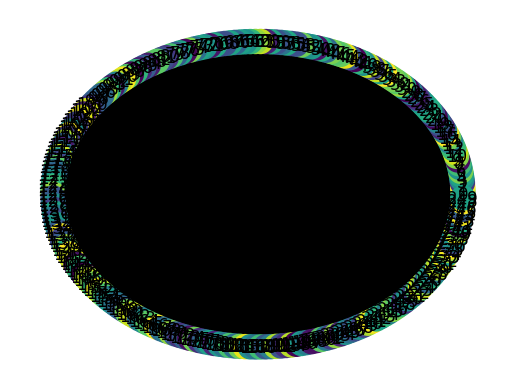

         1003440695 function calls (1003361619 primitive calls) in 664.209 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       14    0.000    0.000  664.425   47.459 /home/kunal/Desktop/Sem_9/DDP/Maxcut/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3541(run_code)
   797/14    0.006    0.000  664.425   47.459 {built-in method builtins.exec}
     29/1    0.002    0.000  661.997  661.997 /tmp/ipykernel_4759/3128703399.py:9(graph_coloring1)
       14    0.061    0.004  555.158   39.654 /tmp/ipykernel_4759/2504352795.py:1(moe_maxcut)
       14    0.000    0.000  554.737   39.624 /home/kunal/Desktop/Sem_9/DDP/Maxcut/mod_one_exchange.py:148(mod_one_exchange_approximation)
       14    0.000    0.000  554.736   39.624 <class 'networkx.utils.decorators.argmap'> compilation 26:1(argmap_mod_one_exchange_21)
       14    0.017    0.001  554.736   39.624 /home/kunal/Desktop/Sem_9/DDP/Maxcut/mod_one_exchange.py

In [8]:
import cProfile, pstats, io
from pstats import SortKey
pr = cProfile.Profile()
pr.enable()
# ... do something ...

threshold = 30
# This attempt uses simple merging without any optimization
def graph_coloring1(adj):
    if adj.shape[0] <= threshold:
        return graph_painter(adj)
    else:
        adj1, adj0, cut, map_index1, map_index0, reverse_map = moe_maxcut(adj)
        colors1 = graph_coloring1(adj1)
        colors0 = graph_coloring1(adj0)
        colors_merged = []
        for color_block in colors1:
            temp_list = []
            for node in color_block:
                temp_list.append(map_index1[node])
            colors_merged.append(temp_list)
        
        for color_block in colors0:
            temp_list = []
            for node in color_block:
                temp_list.append(map_index0[node])
            colors_merged.append(temp_list)

    print(colors_merged)

    return colors_merged

graph_name = 'dsjc250.5'

# read the graph from the file
G = mat_to_graph('test_graphs/' + graph_name + '.mat')

# get the adjacency matrix of the graph
adj = nx.adjacency_matrix(G).todense()
adj = np.asarray(adj, dtype=np.int32)

print(adj)

# get the colors of the graph
colors = graph_coloring1(adj)
color_array, num_colors = get_color_indice_array(colors, adj)
print(colors)

# Draw the graph
fig, ax = plt.subplots()
nx.draw_circular(G, with_labels=True, node_color=color_array, ax=ax)
plt.show()

pr.disable()
s = io.StringIO()
sortby = SortKey.CUMULATIVE
ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
ps.print_stats()
print(s.getvalue())
        

In [7]:
cnt = 0
for color in colors:
    cnt += len(color)
print(cnt)

250


In [8]:
tempx = graph_painter(adj)
print(type(tempx))
print(tempx)

['Process_14']
order-based chromatic number at simulation end:  151
color blocks at simulation end:  [[224, 226], [157], [72, 90], [94], [166, 186, 201, 35], [61], [16], [108, 141], [152], [19, 154], [66, 17], [9, 89], [10, 173], [215, 33], [219, 162], [143], [207, 34, 227], [240], [234], [103, 129], [118, 233], [178], [235], [75], [208, 183], [119], [87, 105], [126, 54, 80], [198], [187, 206], [65], [5, 63], [195, 147], [172, 237, 97], [174], [169], [244, 180], [69], [101], [239, 45], [55, 156], [2], [73], [134, 192], [91, 100], [64, 50], [53], [25], [78, 127], [58], [243, 37], [124, 133], [109, 175], [121], [164, 216], [140], [42], [52], [111], [211, 238], [176], [12, 146], [67, 71], [246, 200, 241], [170], [151, 120, 44], [236, 155], [149, 168], [95], [132, 28], [148, 202], [1], [82, 79, 14], [213, 86, 177], [98, 191, 40], [4, 171], [190], [138], [161], [247, 212, 70], [136, 3], [218], [30], [123], [85], [184], [7, 221], [60], [229, 116], [122], [193], [230], [77], [125], [159, 102]

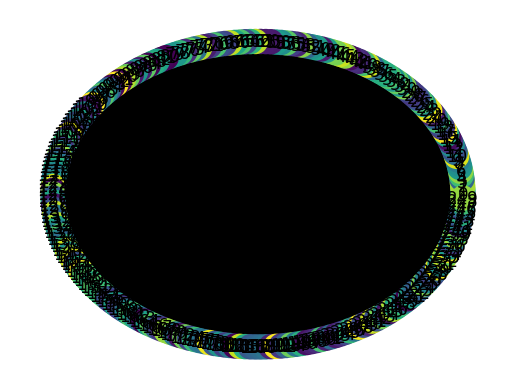

<Figure size 100x100 with 0 Axes>

In [9]:
# Draw the graph
fig, ax = plt.subplots()
# increase the size of the figure
plt.figure(figsize=(1, 1))
nx.draw_circular(G, with_labels=True, node_color=color_array, ax=ax)
plt.show()

In [ ]:
# IGNORE THE CODE AHEAD

In [58]:
def random_cut(G):
    colors = np.random.randint(2, size = G.number_of_nodes())
    cutsize = 0
    for u,v in G.edges():
        if colors[u] != colors[v]:
            cutsize += 1
    return colors, cutsize

def graph_to_mat(G, path = 'test_graphs/default2.mat'):
    # get the adjancency matrix of the graph
    adj = nx.adjacency_matrix(G).todense()
    adj = np.asarray(adj, dtype=np.int32)
    scipy.io.savemat(path, {'M': adj})   # M for matrix, to stay consistent with the .mat files we already have
    return

def mat_to_graph(path):
    mat = scipy.io.loadmat(path)
    G = nx.from_numpy_matrix(mat['M'])
    return G
# The function below would be useful to read temporary results from the subgraphs
def extract_chromatic_info(file_path):
    with open(file_path, 'r') as file:
        text = file.read()
    
    # Extract minimum order-based chromatic number using regex
    min_chromatic_number = int(re.search(r"minimum order-based chromatic number during simulation:  (\d+)", text).group(1))
    
    # Extract color blocks at minimum chromatic number using regex
    color_blocks_str = re.search(r"color blocks at minimum chromatic number:  (\[\[.*\]\])", text).group(1)
    color_blocks = eval(color_blocks_str)  # When you pass the string representation of a list of lists to eval(), 
    # it parses the string and converts it into actual Python objects (in this case, a list of lists of integers).
    
    return min_chromatic_number, color_blocks

In [7]:
col_graph_name = 'dsjc250.1'
G,adj,nnodes = reader.dimacs_reader("test_graphs/{}.col".format(col_graph_name))
# Save as .mat file
graph_to_mat(G, 'test_graphs/{}.mat'.format(col_graph_name))


FileNotFoundError: [Errno 2] No such file or directory: 'test_graphs/dsjc250.1.col'

In [6]:
# Example
# min_chromatic_number_without_maxcut, color_blocks = extract_chromatic_info('temp_output7.txt')

# print(min_chromatic_number_without_maxcut)
# print(color_blocks)
# G,adj,nnodes = reader.dimacs_reader("test_graphs/dsjc250.5.col")
# colors,cutsize = mod_one_exchange_approximation(G)
# colors,cutsize = gw_sdp.goemans_williamson_max_cut(G)
# colors,cutsize = random_cut(G)

In [7]:
def get_subgraphs(G, maxcut_colors):
    # maxcut_colors contain 0s and 1s
    # 0s are the nodes in the first set
    # 1s are the nodes in the second set
    # create two maps, one for each set
    # We proceed in ascending order over the original graph and assign the nodes to the sets
    # according to the maxcut_colors
    first_set = []
    second_set = []
    for i in range(len(maxcut_colors)):
        if maxcut_colors[i] == 0:
            first_set.append(i)
        else:
            second_set.append(i)

    # create the adjacency matrix for the subgraphs
    #
    adj = nx.adjacency_matrix(G).todense()
    adj = np.asarray(adj, dtype=np.int32)

    adj_sub1 = np.zeros((len(first_set), len(first_set)))
    adj_sub2 = np.zeros((len(second_set), len(second_set)))

    for i in range(len(first_set)):
        for j in range(len(first_set)):
            adj_sub1[i][j] = adj[first_set[i]][first_set[j]]

    for i in range(len(second_set)):
        for j in range(len(second_set)):
            adj_sub2[i][j] = adj[second_set[i]][second_set[j]]

    # create the subgraphs
    G_sub1 = nx.from_numpy_matrix(adj_sub1)
    G_sub2 = nx.from_numpy_matrix(adj_sub2)

    return G_sub1, G_sub2, first_set, second_set

In [8]:
def check_validity(G_sub1,G_sub2,G,color_blocks1,color_blocks2,cut,part1,part2):
    colors1 = np.zeros(G_sub1.number_of_nodes())
    colors2 = np.zeros(G_sub2.number_of_nodes())
    color_index = 0
    for i,block in enumerate(color_blocks1):
        for node in block:
            colors1[node] = color_index
        color_index += 1
    for i,block in enumerate(color_blocks2):
        for node in block:
            colors2[node] = color_index
        color_index += 1

    # check if the coloring is valid
    valid_coloring1 = True
    valid_coloring2 = True
    for edges in G_sub1.edges:
        if colors1[edges[0]] == colors1[edges[1]]:
            valid_coloring1 = False
            print("Invalid coloring for subgraph 1")
            print(edges)
    for edges in G_sub2.edges:
        if colors2[edges[0]] == colors2[edges[1]]:
            valid_coloring2 = False
            print("Invalid coloring for subgraph 2")
            print(edges)

    if(valid_coloring1):
        print("Valid coloring for subgraph 1")
    if(valid_coloring2):
        print("Valid coloring for subgraph 2")

    # combine the two colorings
    # Using two pointers approach
    i = 0
    j = 0
    k = 0

    merged_colors = np.zeros(G.number_of_nodes())
    
    while i < G_sub1.number_of_nodes() and j < G_sub2.number_of_nodes():
        if cut[k] == 0:
            merged_colors[part1[i]] = colors1[i]
            i += 1
        else:
            merged_colors[part2[j]] = colors2[j]
            j += 1
        k += 1
    while i < G_sub1.number_of_nodes():
        merged_colors[part1[i]] = colors1[i]
        i += 1
        k += 1

    while j < G_sub2.number_of_nodes():
        merged_colors[part2[j]] = colors2[j]
        j += 1
        k += 1

    # check if the coloring is valid
    valid_coloring = True
    for edges in G.edges:
        if merged_colors[edges[0]] == merged_colors[edges[1]]:
            valid_coloring = False
            print("Invalid coloring for full Graph")
            print(edges)
    if valid_coloring:
        print("Valid coloring for full Graph")
    return merged_colors


def check_reducibility(num_colors, merged_colors, G):
    color_adj = np.zeros((num_colors, num_colors))
    for edges in G.edges():
        color_adj[int(merged_colors[edges[0]])][int(merged_colors[edges[1]])] = 1
        color_adj[int(merged_colors[edges[1]])][int(merged_colors[edges[0]])] = 1
    
    temp_check = np.ones((num_colors,num_colors))-np.eye(num_colors)
    flag = np.array_equal(color_adj,temp_check)
    if flag:
        print("Not reducible")
    else:
        print("Reducible")
    
    print(color_adj)
    return flag, color_adj


def min_chromatic_number(G):
    # Use networkx's greedy_color algorithm to assign colors # Might not be complete
    color_assignment = nx.coloring.greedy_color(G, strategy="largest_first")
    
    # The chromatic number is the maximum color index used + 1
    chromatic_number = max(color_assignment.values()) + 1
    
    # Returning chromatic number and color assignment for nodes
    return chromatic_number, color_assignment


In [37]:
number_of_runs = 4
graph_coloring_min_colors = []
graph_coloring_with_MOE_cut_min_colors = []
graph_coloring_with_MOE_cut_min_colors_optimized = []
graph_coloring_with_random_cut_min_colors = []
graph_coloring_with_random_cut_min_colors_optimized = []
graph_coloring_with_goeman_williamson_min_colors = []
graph_coloring_with_goeman_williamson_min_colors_optimized = []
is_reducible_MOE = []
is_reducible_random_cut = []
is_reducible_goeman_williamson = []

for i in range (1, number_of_runs + 1):
    print("Running for", i, "th time")
    graph_name = 'dsjc125.5'
    G = mat_to_graph('test_graphs/' + graph_name + '.mat')
    
    !python GraphColoringTest.py dsjc125.5 0.01 > temp_output.txt

    min_chromatic_number_without_maxcut, color_blocks = extract_chromatic_info('temp_output.txt')
    graph_coloring_min_colors.append(min_chromatic_number_without_maxcut)
    
    # Running the MOE algorithm
    cut, cutsize = mod_one_exchange_approximation(G)
    G_sub1, G_sub2, first_set, second_set = get_subgraphs(G, cut)

    cut_sub1, cutsize_sub1 = mod_one_exchange_approximation(G_sub1)
    cut_sub2, cutsize_sub2 = mod_one_exchange_approximation(G_sub2)

    graph_to_mat(G_sub1, 'test_graphs/' + graph_name + '_sub1.mat')
    graph_to_mat(G_sub2, 'test_graphs/' + graph_name + '_sub2.mat')

    !python GraphColoringTest.py dsjc125.5_sub1 0.01 > temp_output_sub1.txt
    !python GraphColoringTest.py dsjc125.5_sub2 0.01 > temp_output_sub2.txt

    min_chromatic_number_sub1, color_blocks_sub1 = extract_chromatic_info('temp_output_sub1.txt')
    min_chromatic_number_sub2, color_blocks_sub2 = extract_chromatic_info('temp_output_sub2.txt')

    merged_colors = check_validity(G_sub1, G_sub2, G, color_blocks_sub1, color_blocks_sub2, cut, first_set, second_set)
    graph_coloring_with_MOE_cut_min_colors.append(min_chromatic_number_sub1 + min_chromatic_number_sub2)

    flag, color_adj = check_reducibility(min_chromatic_number_sub1 + min_chromatic_number_sub2, merged_colors, G)
    is_reducible_MOE.append(flag)

    if(flag == False):
        color_graph = nx.from_numpy_matrix(color_adj)
        min_colors_optimized, color_assignment_optimized = min_chromatic_number(color_graph)
        graph_coloring_with_MOE_cut_min_colors_optimized.append(min_colors_optimized)
    else:
        graph_coloring_with_MOE_cut_min_colors_optimized.append(min_chromatic_number_sub1 + min_chromatic_number_sub2)



    # Running the random cut algorithm
    cutsize = 0
    while(cutsize == 0):  # We want to make sure that the subsets are non-empty
        cut, cutsize = random_cut(G)
        G_sub1, G_sub2, first_set, second_set = get_subgraphs(G, cut)

    

    cut_sub1, cutsize_sub1 = random_cut(G_sub1)
    cut_sub2, cutsize_sub2 = random_cut(G_sub2)

    graph_to_mat(G_sub1, 'test_graphs/' + graph_name + '_sub1.mat')
    graph_to_mat(G_sub2, 'test_graphs/' + graph_name + '_sub2.mat')

    !python GraphColoringTest.py dsjc125.5_sub1 0.01 > temp_output_sub1.txt
    !python GraphColoringTest.py dsjc125.5_sub2 0.01 > temp_output_sub2.txt

    min_chromatic_number_sub1, color_blocks_sub1 = extract_chromatic_info('temp_output_sub1.txt')
    min_chromatic_number_sub2, color_blocks_sub2 = extract_chromatic_info('temp_output_sub2.txt')

    merged_colors = check_validity(G_sub1, G_sub2, G, color_blocks_sub1, color_blocks_sub2, cut, first_set, second_set)
    graph_coloring_with_random_cut_min_colors.append(min_chromatic_number_sub1 + min_chromatic_number_sub2)

    flag, color_adj = check_reducibility(min_chromatic_number_sub1 + min_chromatic_number_sub2, merged_colors, G)
    is_reducible_random_cut.append(flag)

    if(flag == False):
        color_graph = nx.from_numpy_matrix(color_adj)
        min_colors_optimized, color_assignment_optimized = min_chromatic_number(color_graph)
        graph_coloring_with_random_cut_min_colors_optimized.append(min_colors_optimized)
    else:
        graph_coloring_with_random_cut_min_colors_optimized.append(min_chromatic_number_sub1 + min_chromatic_number_sub2)

        
    # Running the Goemans-Williamson algorithm
    cut, cutsize = gw_sdp.goemans_williamson_max_cut(G)
    G_sub1, G_sub2, first_set, second_set = get_subgraphs(G, cut)

    cut_sub1, cutsize_sub1 = gw_sdp.goemans_williamson_max_cut(G_sub1)
    cut_sub2, cutsize_sub2 = gw_sdp.goemans_williamson_max_cut(G_sub2)

    graph_to_mat(G_sub1, 'test_graphs/' + graph_name + '_sub1.mat')
    graph_to_mat(G_sub2, 'test_graphs/' + graph_name + '_sub2.mat')

    !python GraphColoringTest.py dsjc125.5_sub1 0.01 > temp_output_sub1.txt
    !python GraphColoringTest.py dsjc125.5_sub2 0.01 > temp_output_sub2.txt

    min_chromatic_number_sub1, color_blocks_sub1 = extract_chromatic_info('temp_output_sub1.txt')
    min_chromatic_number_sub2, color_blocks_sub2 = extract_chromatic_info('temp_output_sub2.txt')

    merged_colors = check_validity(G_sub1, G_sub2, G, color_blocks_sub1, color_blocks_sub2, cut, first_set, second_set)
    graph_coloring_with_goeman_williamson_min_colors.append(min_chromatic_number_sub1 + min_chromatic_number_sub2)

    flag, color_adj = check_reducibility(min_chromatic_number_sub1 + min_chromatic_number_sub2, merged_colors, G)
    is_reducible_goeman_williamson.append(flag)

    if(flag == False):
        color_graph = nx.from_numpy_matrix(color_adj)
        min_colors_optimized, color_assignment_optimized = min_chromatic_number(color_graph)
        graph_coloring_with_goeman_williamson_min_colors_optimized.append(min_colors_optimized)
    else:
        graph_coloring_with_goeman_williamson_min_colors_optimized.append(min_chromatic_number_sub1 + min_chromatic_number_sub2)

Running for 1 th time


/tmp/ipykernel_9273/3790719680.py:18: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G).todense()
/tmp/ipykernel_9273/392366149.py:11: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G).todense()


Valid coloring for subgraph 1
Valid coloring for subgraph 2
Valid coloring for full Graph
Reducible
[[0. 1. 1. ... 1. 1. 1.]
 [1. 0. 1. ... 1. 1. 1.]
 [1. 1. 0. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 0. 1. 1.]
 [1. 1. 1. ... 1. 0. 1.]
 [1. 1. 1. ... 1. 1. 0.]]
Valid coloring for subgraph 1
Valid coloring for subgraph 2
Valid coloring for full Graph
Reducible
[[0. 1. 1. ... 1. 1. 1.]
 [1. 0. 1. ... 1. 1. 1.]
 [1. 1. 0. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 0. 1. 1.]
 [1. 1. 1. ... 1. 0. 1.]
 [1. 1. 1. ... 1. 1. 0.]]


/home/kunal/Desktop/Sem_9/DDP/Maxcut/.venv/lib/python3.10/site-packages/cvxpy/problems/problem.py:158: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "


Valid coloring for subgraph 1
Valid coloring for subgraph 2
Valid coloring for full Graph
Reducible
[[0. 1. 1. ... 1. 1. 1.]
 [1. 0. 1. ... 1. 1. 1.]
 [1. 1. 0. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 0. 1. 1.]
 [1. 1. 1. ... 1. 0. 1.]
 [1. 1. 1. ... 1. 1. 0.]]
Running for 2 th time
Valid coloring for subgraph 1
Valid coloring for subgraph 2
Valid coloring for full Graph
Reducible
[[0. 1. 1. ... 1. 1. 1.]
 [1. 0. 1. ... 0. 1. 1.]
 [1. 1. 0. ... 1. 1. 1.]
 ...
 [1. 0. 1. ... 0. 1. 1.]
 [1. 1. 1. ... 1. 0. 1.]
 [1. 1. 1. ... 1. 1. 0.]]
Valid coloring for subgraph 1
Valid coloring for subgraph 2
Valid coloring for full Graph
Reducible
[[0. 1. 0. ... 1. 1. 1.]
 [1. 0. 1. ... 1. 1. 0.]
 [0. 1. 0. ... 1. 1. 0.]
 ...
 [1. 1. 1. ... 0. 1. 1.]
 [1. 1. 1. ... 1. 0. 1.]
 [1. 0. 0. ... 1. 1. 0.]]
Valid coloring for subgraph 1
Valid coloring for subgraph 2
Valid coloring for full Graph
Reducible
[[0. 1. 1. ... 1. 1. 1.]
 [1. 0. 1. ... 1. 1. 1.]
 [1. 1. 0. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 0. 1. 1.]
 [1. 

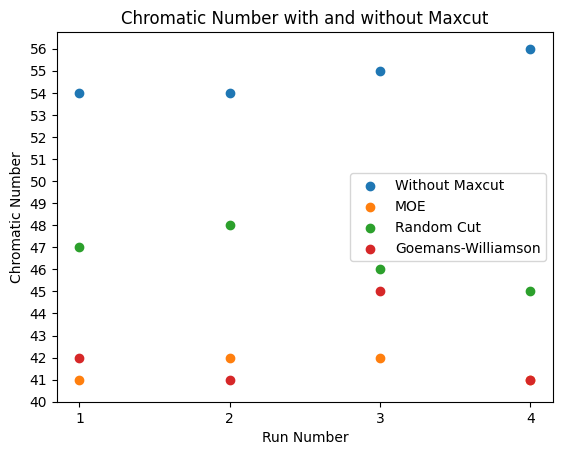

In [38]:
# Making a scatter plot, one for with maxcut and one for without maxcut
# only show integer ticks on the y-axis and x-axis
plt.figure()
plt.scatter(range(1, number_of_runs + 1), graph_coloring_min_colors, label = 'Without Maxcut')
plt.scatter(range(1, number_of_runs + 1), graph_coloring_with_MOE_cut_min_colors, label = 'MOE')
plt.scatter(range(1, number_of_runs + 1), graph_coloring_with_random_cut_min_colors, label = 'Random Cut')
plt.scatter(range(1, number_of_runs + 1), graph_coloring_with_goeman_williamson_min_colors, label = 'Goemans-Williamson')
plt.xticks(np.arange(1, number_of_runs + 1, 1))
plt.yticks(np.arange(min(min(graph_coloring_min_colors),
                         min(graph_coloring_with_MOE_cut_min_colors), 
                         min(graph_coloring_with_random_cut_min_colors), 
                         min(graph_coloring_with_goeman_williamson_min_colors))-1, 
                    max(max(graph_coloring_min_colors), 
                        max(graph_coloring_with_MOE_cut_min_colors), 
                        max(graph_coloring_with_random_cut_min_colors), 
                        max(graph_coloring_with_goeman_williamson_min_colors))+1))
plt.xlabel('Run Number')
plt.ylabel('Chromatic Number')
plt.legend()
plt.title('Chromatic Number with and without Maxcut')
plt.show()


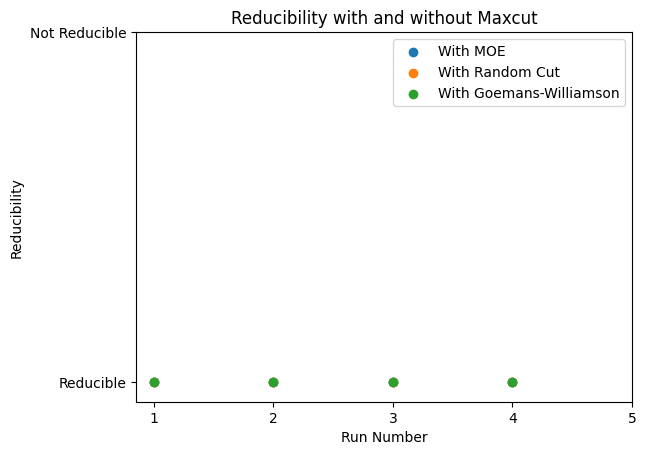

In [39]:
# make a scatter plot for reducibility
plt.figure()
plt.scatter(range(1, number_of_runs + 1), is_reducible_MOE, label = 'With MOE')
plt.scatter(range(1, number_of_runs + 1), is_reducible_random_cut, label = 'With Random Cut')
plt.scatter(range(1, number_of_runs + 1), is_reducible_goeman_williamson, label = 'With Goemans-Williamson')
plt.xticks(range(1, number_of_runs + 2))
plt.yticks([0,1], ['Reducible', 'Not Reducible'])
plt.xlabel('Run Number')
plt.ylabel('Reducibility')
plt.legend()
plt.title('Reducibility with and without Maxcut')
plt.show()

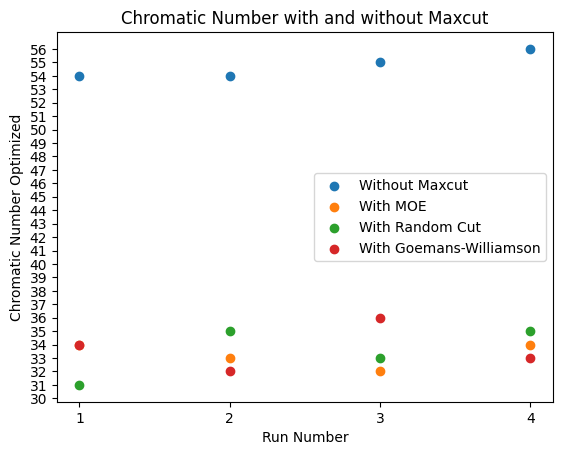

In [46]:
# Making a scatter plot, one for with maxcut and one for without maxcut
# only show integer ticks on the y-axis and x-axis
plt.figure()
plt.scatter(range(1, number_of_runs + 1), graph_coloring_min_colors, label = 'Without Maxcut')
plt.scatter(range(1, number_of_runs + 1), graph_coloring_with_MOE_cut_min_colors_optimized, label = 'With MOE')
plt.scatter(range(1, number_of_runs + 1), graph_coloring_with_random_cut_min_colors_optimized, label = 'With Random Cut')
plt.scatter(range(1, number_of_runs + 1), graph_coloring_with_goeman_williamson_min_colors_optimized, label = 'With Goemans-Williamson')
plt.xticks(np.arange(1, number_of_runs + 1, 1))
plt.yticks(np.arange(min(min(graph_coloring_min_colors),
                         min(graph_coloring_with_MOE_cut_min_colors_optimized),
                         min(graph_coloring_with_random_cut_min_colors_optimized),
                         min(graph_coloring_with_goeman_williamson_min_colors_optimized))-1,
                    max(max(graph_coloring_min_colors),
                        max(graph_coloring_with_MOE_cut_min_colors_optimized),
                        max(graph_coloring_with_random_cut_min_colors_optimized),
                        max(graph_coloring_with_goeman_williamson_min_colors_optimized))+1))

plt.xlabel('Run Number')
plt.ylabel('Chromatic Number Optimized')
plt.legend()
plt.title('Chromatic Number with and without Maxcut')
plt.show()


In [41]:
# save all the results in a dataframe
import pandas as pd
results = pd.DataFrame({'graph_coloring_min_colors': graph_coloring_min_colors,
                        'graph_coloring_with_MOE_cut_min_colors': graph_coloring_with_MOE_cut_min_colors,
                        'graph_coloring_with_random_cut_min_colors': graph_coloring_with_random_cut_min_colors,
                        'graph_coloring_with_goeman_williamson_min_colors': graph_coloring_with_goeman_williamson_min_colors,
                        'is_reducible_MOE': is_reducible_MOE,
                        'is_reducible_random_cut': is_reducible_random_cut,
                        'is_reducible_goeman_williamson': is_reducible_goeman_williamson,
                        'graph_coloring_with_MOE_cut_min_colors_optimized': graph_coloring_with_MOE_cut_min_colors_optimized,
                        'graph_coloring_with_random_cut_min_colors_optimized': graph_coloring_with_random_cut_min_colors_optimized,
                        'graph_coloring_with_goeman_williamson_min_colors_optimized': graph_coloring_with_goeman_williamson_min_colors_optimized})

# Save by the name of the graph
results.to_csv('results_' + graph_name + '.csv')


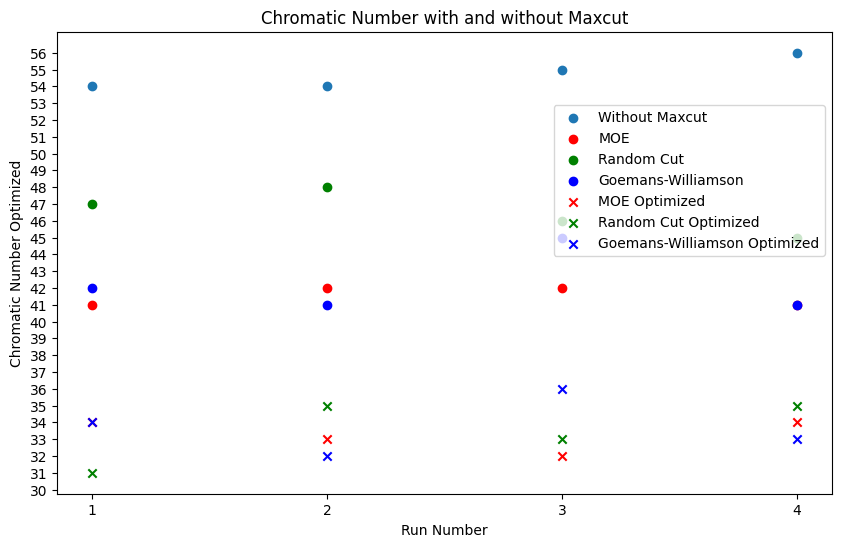

In [42]:
plt.figure(figsize=(10, 6))
plt.scatter(range(1, number_of_runs + 1), graph_coloring_min_colors, label = 'Without Maxcut')
plt.scatter(range(1, number_of_runs + 1), graph_coloring_with_MOE_cut_min_colors, label = 'MOE', marker = 'o', color = 'r')
plt.scatter(range(1, number_of_runs + 1), graph_coloring_with_random_cut_min_colors, label = 'Random Cut', marker = 'o', color = 'g')
plt.scatter(range(1, number_of_runs + 1), graph_coloring_with_goeman_williamson_min_colors, label = 'Goemans-Williamson', marker = 'o', color = 'b')
plt.scatter(range(1, number_of_runs + 1), graph_coloring_with_MOE_cut_min_colors_optimized, label = 'MOE Optimized', marker = 'x', color = 'r')
plt.scatter(range(1, number_of_runs + 1), graph_coloring_with_random_cut_min_colors_optimized, label = 'Random Cut Optimized', marker = 'x', color = 'g')
plt.scatter(range(1, number_of_runs + 1), graph_coloring_with_goeman_williamson_min_colors_optimized, label = 'Goemans-Williamson Optimized', marker = 'x', color = 'b')

plt.xticks(np.arange(1, number_of_runs + 1, 1))
plt.yticks(np.arange(min(min(graph_coloring_min_colors),
                         min(graph_coloring_with_MOE_cut_min_colors_optimized),
                         min(graph_coloring_with_random_cut_min_colors_optimized),
                         min(graph_coloring_with_goeman_williamson_min_colors_optimized))-1,
                    max(max(graph_coloring_min_colors),
                        max(graph_coloring_with_MOE_cut_min_colors_optimized),
                        max(graph_coloring_with_random_cut_min_colors_optimized),
                        max(graph_coloring_with_goeman_williamson_min_colors_optimized))+1))

plt.xlabel('Run Number')
plt.ylabel('Chromatic Number Optimized')
# show legend seperately
plt.legend(loc='lower right', bbox_to_anchor=(1, 0.5))
plt.title('Chromatic Number with and without Maxcut')
plt.show()

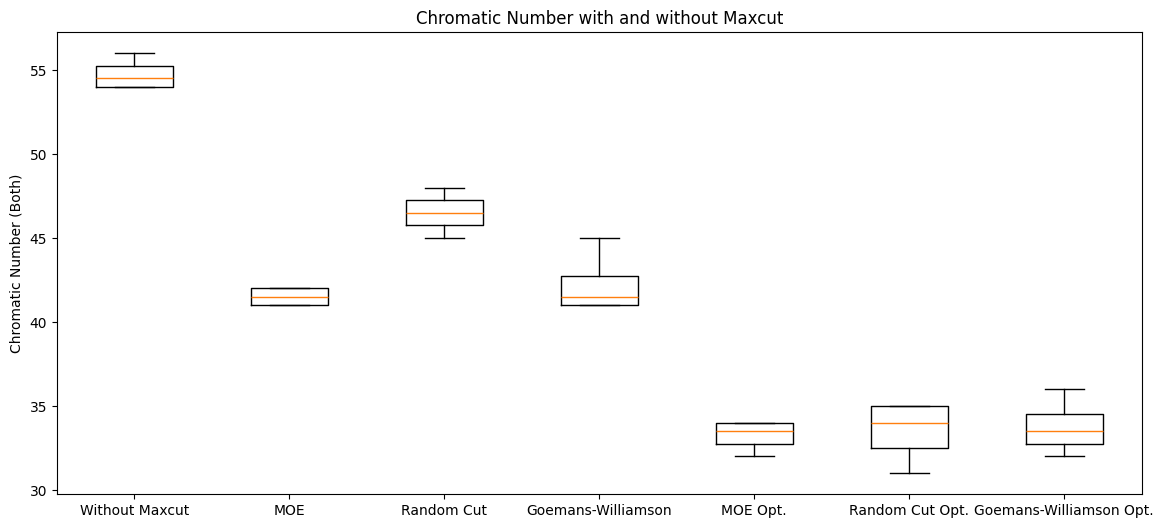

In [43]:
plt.figure(figsize=(14, 6))
plt.boxplot([graph_coloring_min_colors, graph_coloring_with_MOE_cut_min_colors, graph_coloring_with_random_cut_min_colors, 
             graph_coloring_with_goeman_williamson_min_colors, graph_coloring_with_MOE_cut_min_colors_optimized, 
             graph_coloring_with_random_cut_min_colors_optimized, graph_coloring_with_goeman_williamson_min_colors_optimized])
plt.xticks([1, 2, 3, 4, 5, 6, 7], ['Without Maxcut', 'MOE', 'Random Cut', 'Goemans-Williamson',
                           'MOE Opt.', 'Random Cut Opt.', 'Goemans-Williamson Opt.'])
plt.ylabel('Chromatic Number (Both)')

plt.title('Chromatic Number with and without Maxcut')
plt.show()

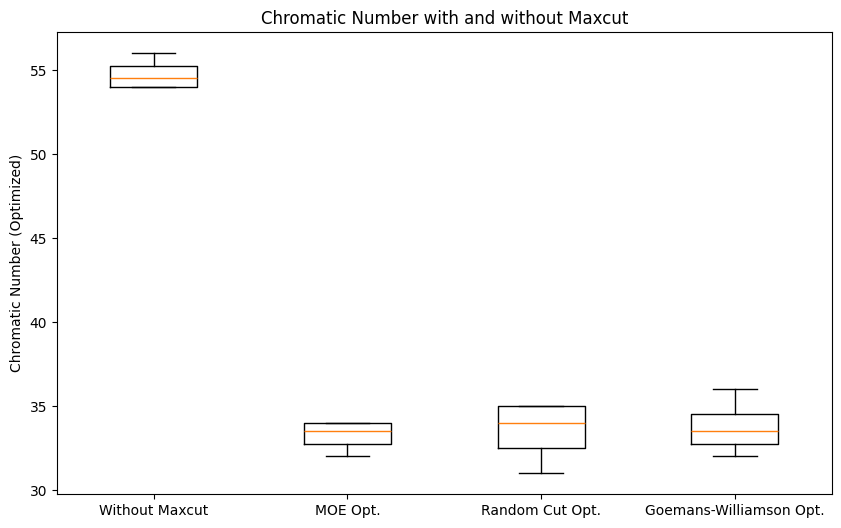

In [44]:
# Making a box plot, one for maxcut with each method and one for without maxcut

plt.figure(figsize=(10, 6))
plt.boxplot([graph_coloring_min_colors, graph_coloring_with_MOE_cut_min_colors_optimized, graph_coloring_with_random_cut_min_colors_optimized, graph_coloring_with_goeman_williamson_min_colors_optimized])
plt.xticks([1, 2, 3, 4], ['Without Maxcut', 'MOE Opt.', 'Random Cut Opt.', 'Goemans-Williamson Opt.'])
plt.ylabel('Chromatic Number (Optimized)')

plt.title('Chromatic Number with and without Maxcut')
plt.show()

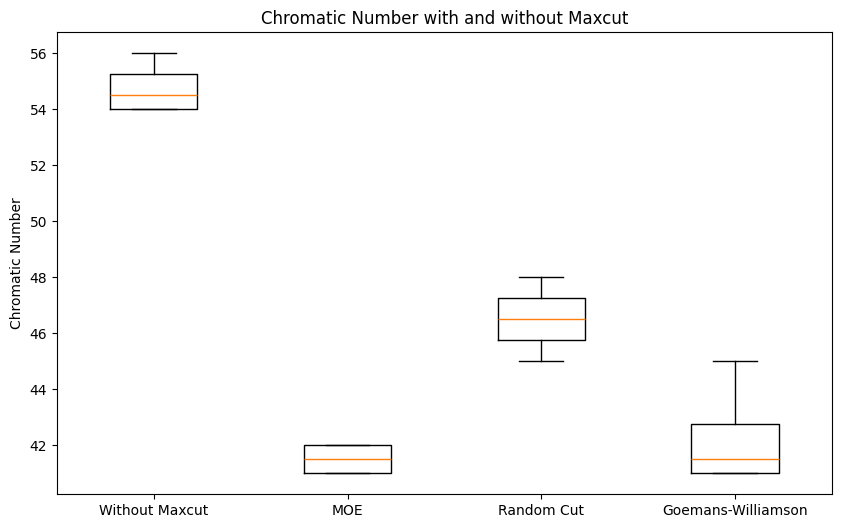

In [45]:
# Making a box plot, one for maxcut with each method and one for without maxcut

plt.figure(figsize=(10, 6))
plt.boxplot([graph_coloring_min_colors, graph_coloring_with_MOE_cut_min_colors, graph_coloring_with_random_cut_min_colors, graph_coloring_with_goeman_williamson_min_colors])
plt.xticks([1, 2, 3, 4], ['Without Maxcut', 'MOE', 'Random Cut', 'Goemans-Williamson'])
plt.ylabel('Chromatic Number')

plt.title('Chromatic Number with and without Maxcut')
plt.show()